# Preparation

In [ ]:
!ls

sample_data




*   Check local device



In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12364962989792988629, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4862732892118252983
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16310012740012472981
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7298761376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17041362724306277236
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]



*   Import libraries

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow

from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")  # Ignore some warning logs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras import regularizers

from skimage.measure import block_reduce

from skimage.feature import hog

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import time

from google.colab import files

# All functions and data initialization



##   Functions



In [ ]:
def importFile(filename):
    datafile = csv.reader(open(filename,'r'))
    data = []
    label = []
    
    for idx, row in enumerate(datafile):
        if idx == 0:
            continue
        else:
            data.append(row[1].split(' '))
            label.append(float(row[0]))
            
    for idx, line in enumerate(data):
        data[idx] = [float(ele) for ele in line]
        
    return np.array(data), np.array(label)

# Visualize 7 random images from training set for each emotion
def displayImages(data,label,savefig):
    imgIdx = []
    
    np.random.seed(0)
    for i in range(7):
        idx = np.where(label==i)[0] # Find indices of images that belong to class(emotion) i
        imgIdx.append(np.random.choice(idx)) # Randomly select one of the images and save the index
    imgIdx = np.array(imgIdx).flatten()
    
    plt.figure(figsize=(6*3,7*3))
    for i in range(7):
        plt.subplot(3,3,i+1)
        plt.imshow(data[imgIdx[i]].reshape(48,48))
        plt.title("Emotion {}".format(i))
    #plt.suptitle("Three random samples from training set")
    
    if savefig == True:
        plt.savefig("Random samples.png",dpi=160)
        
# FNN
def FNN(nlayer,act,dropout,train,trainLabel,epoch,inputSize,verbose,figure):
    layers = [
        Dense(inputSize, activation = act, input_shape=(inputSize,), name="1st_hidden_layer"),Dropout(dropout),#0,1
        Dense(inputSize//2, activation = act, name="2nd_hidden_layer"),Dropout(dropout),#2,3
        Dense(inputSize//4, activation = act, name="3rd_hidden_layer"),Dropout(dropout),#4,5
        Dense(inputSize//8, activation = act, name="4th_hidden_layer"),Dropout(dropout),#6,7
        Dense(inputSize//16, activation = act, name="5th_hidden_layer"),Dropout(dropout),#8,9
        Dense(inputSize//32, activation = act, name="6th_hidden_layer"),Dropout(dropout),#10,11
        Dense(7, activation = 'softmax'),]
    
    model = Sequential([layers[i] for i in nlayer]+[layers[12]])
    print(model.summary())
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)
    
    begin = time.time()
    #train = np.array(train).reshape((-1,24*24))
    values = model.fit(train, to_categorical(trainLabel), epochs=epoch, batch_size=128,verbose=verbose)
    complete = time.time()

    print("Training acc: {}\n Running time: {}".format(values.history['accuracy'][-1],complete-begin))
    if figure == True:
      plt.plot(values.history['loss'])
      plt.grid(axis='both')
      plt.title("Loss over iterations")
      plt.ylabel("Loss")
      plt.savefig("Loss 1.png",dpi=160)

      files.download("Loss 1.png")
      
    
    return model

# FNN optimize
def FNNoptimizer(hyperparameter):
  model = FNN(hyperparameter['nlayer'],hyperparameter['activation'],hyperparameter['dropout'],
              dataStd.numpy().reshape((-1,24*24)),label,30,24*24,0,False)
  performance = model.evaluate(np.array(dataValStd).reshape((-1,24*24)),to_categorical(labelVal),verbose=0)

  print("Hyperparameters: ", hyperparameter, "Accuracy: ", performance[1])
  print("----------------------------------------------------")
  # We want to minimize loss i.e. negative of accuracy
  return({"status": STATUS_OK, "loss": -1*performance[1], "model":model})

# CNN
def CNN(nlayer,denseLayers,kernelSize,stride,act,dropout,train,trainLabel,epoch,verbose,inputSize):
    layers = [
            Conv2D(32, kernel_size=kernelSize, strides = stride, activation=act, input_shape=inputSize), #0
            Conv2D(32, kernel_size=kernelSize, strides = stride, activation=act), #1
            MaxPooling2D(pool_size=(2,2)), Dropout(dropout), #2,3
            Conv2D(64, kernel_size=kernelSize, strides = stride, activation=act), #4
            Conv2D(64, kernel_size=kernelSize, strides = stride, activation=act), #5
            MaxPooling2D(pool_size=(2,2)), Dropout(dropout), #6,7
            Conv2D(32, kernel_size=kernelSize, strides = stride, activation=act), #8
            Conv2D(32, kernel_size=kernelSize, strides = stride, activation=act), #9
            MaxPooling2D(pool_size=(2,2)), Dropout(dropout), #10,11
            Flatten(), #12
            ]
    model = Sequential([layers[i] for i in nlayer]+[layers[12]]+denseLayers)
    print(model.summary())
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'],)

    begin = time.time()
    values = model.fit(train, to_categorical(trainLabel), epochs = epoch, batch_size = 128, verbose = verbose)
    complete = time.time()

    print("Training accuracy: {}\nTraining time: {}".format(values.history['accuracy'][-1], complete-begin))

    return model

# CNN optimize
def CNNoptimizer(hyperparameter):
  denselayer = [Dense(512,activation='relu'),
              Dense(256,activation='relu'),
              Dense(7,activation='softmax'),]
  model = CNN(hyperparameter['nlayer'],denselayer,hyperparameter['kernelSize'],hyperparameter['stride'],
              hyperparameter['activation'],hyperparameter['dropout'],dataStd,label,30,0,(48,48,1))
  performance = model.evaluate(dataValStd,to_categorical(labelVal),verbose=0)

  print("Hyperparameters: ", hyperparameter, "Accuracy: ", performance[1])
  print("----------------------------------------------------")

  return({"status": STATUS_OK, "loss": -1*performance[1], "model":model})
    



##   Data


In [ ]:
# Import files
data,label = importFile('Q2_Train_Data.csv')
dataVal, labelVal = importFile('Q2_Validation_Data.csv')
dataTest, labelTest = importFile('Q2_Test_Data.csv')

# Downsample data to dimension 24*24 for faster processing - FNN
dataCompress = block_reduce(data.reshape(-1,48,48),block_size=(1,2,2),func=np.mean)
#plt.imshow(data[0])
dataValCompress = block_reduce(dataVal.reshape(-1,48,48),block_size=(1,2,2),func=np.mean)
dataTestCompress = block_reduce(dataTest.reshape(-1,48,48),block_size=(1,2,2),func=np.mean)

# Preprocess images
size = 24
dataStd = tensorflow.image.per_image_standardization(dataCompress.reshape(28709,size,size,1))
dataValStd = tensorflow.image.per_image_standardization(dataValCompress.reshape(3589,size,size,1))
dataTestStd = tensorflow.image.per_image_standardization(dataTestCompress.reshape(3589,size,size,1))

# Original image - 48x48 for CNN
# size = 48
# dataStd = tensorflow.image.per_image_standardization(data.reshape(28709,size,size,1))
# dataValStd = tensorflow.image.per_image_standardization(dataVal.reshape(3589,size,size,1))
# dataTestStd = tensorflow.image.per_image_standardization(dataTest.reshape(3589,size,size,1))

# FNN

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  7 10:54:43 2020

@author: Ziqi Zhao (Astra Joan)
"""

'''
    main program
'''
#displayImages(data,label,True)

# # FNN model
# modelFNN = FNN([0,4,5],'relu',0.1,dataStd.numpy().reshape((-1,24*24)),label,30,24*24,1)
# modelFNN.evaluate(np.array(dataValStd).reshape((-1,24*24)),to_categorical(labelVal))
# modelFNN.evaluate(np.array(dataTestStd).reshape((-1,24*24)),to_categorical(labelTest))

# Optimize FNN
space = {
    # Uniform distribution in finding appropriate dropout values
    'dropout': hp.uniform('dropout', 0.05, 0.35),
    # Choice of activation
    'activation': hp.choice('activation',['relu','tanh','selu']),
    # Choice of layers
    'nlayer': hp.choice('nlayer',[[0,1,2,3],[0,2,3],[0,1,4,5],[0,4,5],[0,4,5,8,9]]),
}

trials = Trials()

best = fmin(
        FNNoptimizer,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=25,
    )

print("==================================")
print("Best Hyperparameters", best)

test_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

performance = test_model.evaluate(dataTestStd.numpy().reshape((-1,24*24)), to_categorical(labelTest))


print("==================================")
print("Test Accuracy: ", performance[1])





    



*   Plot learning curve








In [ ]:
# FNN model
modelFNN = FNN([0,2,3],'relu',0.0874299865012898,dataStd.numpy().reshape((-1,24*24)),label,30,24*24,0,True)
modelFNN.evaluate(np.array(dataValStd).reshape((-1,24*24)),to_categorical(labelVal))
modelFNN.evaluate(np.array(dataTestStd).reshape((-1,24*24)),to_categorical(labelTest))

# CNN

### CNN optimizer

In [ ]:
space = {
    'nlayer': hp.choice('nlayer',[[0,2,3,4,6,7],[0,1,2,3],[0,2,3,8,10,11],[0,2,3]]),
    'kernelSize': hp.choice('kernelSize',[1,3,5]),
    'stride': hp.choice('stride',[1,2]),
    'activation': hp.choice('activation', ['relu','selu','tanh']),
    'dropout': hp.uniform('dropout',0,0.35),
}

trials = Trials()

best = fmin(
    CNNoptimizer,
    space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10,
)

print("==================================")
print("Best Hyperparameters", best)

test_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

performance = test_model.evaluate(dataTestStd, to_categorical(labelTest))

print("==================================")
print("Test Accuracy: ", performance[1])

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_186 (Conv2D)          (None, 22, 22, 32)        832       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 4, 4, 64)          51264     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 256)             

### CNN test



*   Test on one defined model



In [ ]:
nlayer = [0,1,2,3,4,5,6,7]
denselayer = [Dense(512,activation='relu'),
              Dense(256,activation='relu'),
              Dense(7,activation='softmax',name="output"),]
model = CNN(nlayer,denselayer,3,1,'relu',0.2,dataStd.numpy(),label,10,1,(48,48,1))

model.evaluate(dataValStd,to_categorical(labelVal))
model.evaluate(dataTestStd,to_categorical(labelTest))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 9, 64)        

[1.792760968208313, 0.5859571099281311]



*   Get layer output



In [ ]:
layer_name = 'output'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(dataStd)
print(intermediate_output[16])

[3.7036571e-06 2.6306690e-09 1.5213527e-04 9.9606675e-01 3.5831220e-03
 1.7499485e-07 1.9414857e-04]


# Fine tuning

### Pre train on MNIST

In [ ]:
from keras.datasets import mnist

def preTrain(common_features,classifier,train,labels,test,testLabels,verbose):
  #plt.imshow(train.numpy()[0].reshape(28,28))

  cnn_model = Sequential(common_features+classifier)
  print(cnn_model.summary())
  cnn_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'],)

  cnn_model.fit(train, to_categorical(labels), epochs=30, batch_size=256, verbose = verbose)

  performance = cnn_model.evaluate(test, to_categorical(testLabels))
  print("Accuracy on Test samples: {0}".format(performance[1]))

  return cnn_model

# Pre train
(train, labels), (test, test_labels) = mnist.load_data()

# Preprocess images
size = 28
train = tensorflow.image.per_image_standardization(train.reshape(60000,size,size,1))
test = tensorflow.image.per_image_standardization(test.reshape(10000,size,size,1))

common_features = [Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1)), 
              Conv2D(32, kernel_size=3, activation='relu'), 
              MaxPooling2D(pool_size=(2,2)),
              Conv2D(64, kernel_size=3, activation='relu'),
              Conv2D(64, kernel_size=3, activation='relu'), 
              MaxPooling2D(pool_size=(2,2)), Flatten(),]
classifier = [Dense(512, activation='relu'), Dense(10, activation='softmax'),]

preTrained = preTrain(common_features,classifier,train,labels,test,test_labels,0)


11493376/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________

### Fine tuning with FER

In [ ]:
# Fine tuning optimizer
def fineOptimizer(hyperparameter):
  transferCommonFeat = [Conv2D(32, kernel_size=3, activation='relu', input_shape=(48,48,1), 
                               kernel_regularizer=hyperparameter['regularize'],), #0
              Conv2D(32, kernel_size=3, activation='relu',kernel_regularizer=hyperparameter['regularize']), #1
              MaxPooling2D(pool_size=(2,2)), #2
              Conv2D(64, kernel_size=3, activation='relu',kernel_regularizer=hyperparameter['regularize']), #3
              Conv2D(64, kernel_size=3, activation='relu',kernel_regularizer=hyperparameter['regularize']), #4
              MaxPooling2D(pool_size=(2,2)), Flatten(),]
  classifier = [Dense(512, activation='relu',kernel_regularizer=hyperparameter['regularize']), 
                Dense(7, activation='softmax',kernel_regularizer=hyperparameter['regularize']),]
  transferred = Sequential(transferCommonFeat + classifier)

  for l in transferCommonFeat:
    l.trainable = False

  for i in hyperparameter['nlayer']:
    transferCommonFeat[i].trainable = True

  for i in range(len(transferCommonFeat)):
    transferred.layers[i].set_weights(preTrained.layers[i].get_weights())

  print(transferred.summary())

  transferred.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'],)

  begin = time.time()
  values = transferred.fit(dataStd, to_categorical(label), epochs=5, batch_size=256,verbose=0)
  complete = time.time()

  performance = transferred.evaluate(dataValStd, to_categorical(labelVal),verbose=0)
  print("\n\nTraining accuracy: {}".format(values.history['accuracy'][-1]))
  print("Accuracy on Validation samples: {0}".format(performance[1]))
  print("Training time: {} for 5 epochs\n\n".format(complete-begin))
  
  print("Hyperparameters: ", hyperparameter)
  print("----------------------------------------------------")

  return({"status": STATUS_OK, "loss": -1*performance[1], "model":transferred})

space = {
    'nlayer': hp.choice('nlayer',[[],[4],[3,4],[1]]),
    'regularize': hp.choice('regularize',[regularizers.l1(1e-4),regularizers.l2(1e-5),regularizers.l2(1e-4)]),
}

trials = Trials()

best = fmin(
        fineOptimizer,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=10,
    )

print("==================================")
print("Best Hyperparameters", best)

test_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

performance = test_model.evaluate(dataTestStd, to_categorical(labelTest))

print("==================================")
print("Test Accuracy: ", performance[1])





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)             

### Test on one transferred model

In [ ]:
# Pre trained model
for l in common_features:
  l.trainable = False

print(preTrained.summary())

# Transferred model
transferCommonFeat = [Conv2D(32, kernel_size=3, activation='relu', input_shape=(48,48,1)), 
              Conv2D(32, kernel_size=3, activation='relu'), 
              MaxPooling2D(pool_size=(2,2)),
              Conv2D(64, kernel_size=3, activation='relu'),
              Conv2D(64, kernel_size=3, activation='relu'), 
              MaxPooling2D(pool_size=(2,2)), Flatten(),]
classifier = [Dense(512, activation='relu'), Dense(7, activation='softmax'),]
transferred = Sequential(transferCommonFeat + classifier)

for l in transferCommonFeat:
  l.trainable = False

for i in range(len(transferCommonFeat)):
  transferred.layers[i].set_weights(preTrained.layers[i].get_weights())

print(transferred.summary())

transferred.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'],)

begin = time.time()
transferred.fit(dataStd, to_categorical(label), epochs=5, batch_size=256,)
complete = time.time()

performance = transferred.evaluate(dataValStd, to_categorical(labelVal))
print("\n\nAccuracy on Validation samples: {0}\n\n".format(performance[1]))
print("Training time: {} for 5 epochs\n\n".format(complete-begin))

performance = transferred.evaluate(dataTestStd, to_categorical(labelTest))
print("Accuracy on test set: {}".format(performance[1]))





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

### Training from scratch with the same number of epochs

In [ ]:
feats = [Conv2D(32, kernel_size=3, activation='relu', input_shape=(48,48,1),kernel_regularizer=regularizers.l2(1e-5)), 
              Conv2D(32, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(1e-5)), 
              MaxPooling2D(pool_size=(2,2)),
              Conv2D(64, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(1e-5)),
              Conv2D(64, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(1e-5)), 
              MaxPooling2D(pool_size=(2,2)), Flatten(),]
classifier = [Dense(512, activation='relu',kernel_regularizer=regularizers.l2(1e-5)), Dense(7, activation='softmax',kernel_regularizer=regularizers.l2(1e-5)),]
fundamentalCNN = Sequential(feats + classifier)

print(fundamentalCNN.summary())

fundamentalCNN.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'],)

begin = time.time()
values = fundamentalCNN.fit(dataStd, to_categorical(label), epochs=5, batch_size=256,)
complete = time.time()

performance = fundamentalCNN.evaluate(dataValStd, to_categorical(labelVal))
print(values.history['accuracy'][-1])
print("\n\nAccuracy on Validation samples: {0}\n\n".format(performance[1]))
print("Training time: {} for 5 epochs\n\n".format(complete-begin))

performance = fundamentalCNN.evaluate(dataTestStd, to_categorical(labelTest))
print("Accuracy on test set: {}".format(performance[1]))



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 5184)            

### Test if weights are set correctly

In [ ]:
w1 = np.array(preTrained.layers[0].get_weights())
w2 = np.array(transferred.layers[0].get_weights())
w3 = np.array(fundamentalCNN.layers[0].get_weights())
count = [0 for i in range(len(w1))]
for i in range(len(w1)):
  count[i] = 0 if w1[i].all() == w2[i].all() else 1

print(sum(count))
print("\n")

# print(w1)
# print("\n\n")
# print(w2)
# print("\n\n")
# print(w3)

# Feature extraction

### HOG

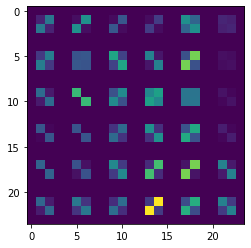

In [ ]:
hogFeatures = []
hogImgs = []
for image in dataStd.numpy().reshape(-1,24,24):
  feature, img = hog(image, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
  hogFeatures.append(feature)
  hogImgs.append(img)

hogFeaturesVal = []
for image in dataValStd.numpy().reshape(-1,24,24):
  feature, img = hog(image, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
  hogFeaturesVal.append(feature)

hogFeaturesTest = []
for image in dataTestStd.numpy().reshape(-1,24,24):
  feature, img = hog(image, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
  hogFeaturesTest.append(feature)

hogFeatures = np.array(hogFeatures)
hogImgs = np.array(hogImgs)
hogFeaturesVal = np.array(hogFeaturesVal)
hogFeaturesTest = np.array(hogFeaturesTest)

plt.imshow(hogImgs[0])

In [ ]:
hogFeatures.shape
# hogImgs.shape

(28709, 72)

### Training with HOG features using FNN

In [ ]:
model = FNN([0,1,2,3],'relu',0.1,hogFeatures,label,30,288,1,False)
performance = model.evaluate(hogFeaturesVal,to_categorical(labelVal))
acc = model.evaluate(hogFeaturesTest,to_categorical(labelTest))
print("\n\n")
print("Accuracy on validation: {}".format(performance[1]))
print("Accuracy on test set: {}".format(acc[1]))


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_hidden_layer (Dense)     (None, 288)               83232     
_________________________________________________________________
dropout_66 (Dropout)         (None, 288)               0         
_________________________________________________________________
2nd_hidden_layer (Dense)     (None, 144)               41616     
_________________________________________________________________
dropout_67 (Dropout)         (None, 144)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 1015      
Total params: 125,863
Trainable params: 125,863
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.7327 - accuracy: 0.3011
Epoch 2/

# Variable test

In [ ]:
# Visualize image after different processing steps
fig, ax = plt.subplots(1,4)
ax[0].imshow(np.array(data)[1].reshape(48,48))
ax[1].imshow(np.array(dataCompress)[1].reshape(24,24))
ax[2].imshow(np.array(dataStd)[1].reshape(24,24))
ax[3].imshow(dataStd[1].numpy().reshape(24,24))

import tensorflow.compat.v1 as tfc
sess = tfc.InteractiveSession()

i = 10
fig, ax = plt.subplots(1,4)
ax[0].hist(data[1][i])
ax[1].hist(dataCompress[1][i],bins=10)
ax[2].hist(np.array(dataStd)[1][i].reshape(24,),bins=10)
ax[3].hist(dataStd[1][i].numpy().reshape(24,),bins=10)

# Check output dimensions
print(np.array(dataValStd).reshape((-1,24*24)).shape)

# print(dataStd[1][0])
# print(np.array(dataStd)[1][0])
# print(dataStd[1][0].numpy())

count = [1 if np.array(dataStd)[1][0][i]==dataStd[1][0][i].numpy() else 0 for i in range(24)]
print("Counts: {}".format(count))

print(label.shape)



##   Test my model on MNIST



In [ ]:
# from keras.datasets import mnist

# #Load MNISt dataset
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# # Check number of samples (60000 in training and 10000 in test)
# # Each image has 28 x 28 pixels
# print("Train Image Shape: ", train_images.shape, "Train Label Shape: ", train_labels.shape) 
# print("Test Image Shape: ", test_images.shape, "Test Label Shape: ", test_labels.shape) 

# #  Visualizing a random image (11th) from training dataset
# print("Visualizing a random image (11th) from training dataset")
# _ = plt.imshow(train_images[10])
# print(type(train_images))
# print(train_labels)

# # Preprocessing: Normalize the images.
# train_images = (train_images / 255) - 0.5
# test_images = (test_images / 255) - 0.5

# flatten_train_images = train_images.reshape((-1, 28*28))
# flatten_test_images = test_images.reshape((-1, 28*28))

# model = FNN([0,2,3],'relu',0.25,flatten_train_images,train_labels,10,28*28)
# model.evaluate(flatten_test_images, to_categorical(test_labels))

# Q1

In [ ]:
datafile = csv.reader(open('Q1_Data.csv','r'))
x = []
for idx, row in enumerate(datafile):
  x.append(float(row[0]))
x = np.array(x).flatten()
print(x)
print(np.mean(x))
sigma = (1/len(x))*sum(pow((x-np.mean(x)),2))
print(sigma)

[1.74365892 0.77479243 1.08425521 1.65314181 1.42333048 0.34849753
 0.98571391 0.89924994 0.63916281 0.83152765 0.97218407 1.15404443
 1.06556385 0.89901814 1.04652781 1.22095058 0.67641151 1.30701084
 1.32147193 0.8177826  1.05729185 0.97390133 1.43961292 1.15420098
 1.01512827 1.03892414 0.70816937 1.01111884 0.92211973 1.15977743
 0.87792311 1.19008299 1.0018162  1.35581395 0.75748035 1.049495
 1.35245024 1.00018937 1.49955715 1.21273403 1.11366741 0.65215762
 0.95530998 1.15567288 1.35066255 1.54493354 0.62965846 0.57853945
 1.23484198 1.70034212]
1.0711573934217318
0.08840831592001709
